In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel

from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


# Load data and clean

In [20]:
df = pd.read_csv('Layoff.csv',encoding='cp1252')
df = df.drop(['Company', 'City', 'State', 'Closure/Layoff','Temporary/Permanent', 'Effective Date','Union','Region','County'], axis=1)
df['WARN Received Date'] = pd.to_datetime(df['WARN Received Date'])
df['by_month'] = df['WARN Received Date'].dt.strftime("%Y-%m")
df = df[(df.by_month<'2020-03')|(df.by_month>'2021-09')].copy()
# Check for missing values
df.isna().sum()
df.head()

,Number of Workers,WARN Received Date,Industry,Open,High,Low,Close,Volume,CPI,PPI,...,Date,Hire_quite_jolts,Job_seekers_ratio,hires_sm,quits_sm,layoffs_sm,actual_hire,log_num_of_workers,layoff_category_by_log,layoff_category_by_num
0,489.0,2020-02-26,Consumer Discretionary Select Sector SPDR Fund,123.1900,124.33000,121.18000,121.49000,12360390.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,6.192362,3,3
1,96.0,2020-02-17,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.564348,3,2
2,95.0,2020-02-17,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.553877,3,2
3,87.0,2020-02-17,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.465908,3,2
4,75.0,2020-02-17,Consumer Discretionary Select Sector SPDR Fund,27.4344,27.71252,26.96252,27.22188,124920.0,2.334874,196.7,...,2020-02,1.7,0.82,3.933333,2.333333,1.266667,27556.933333,4.317488,3,2


In [3]:
quantiles = df['Number of Workers'].quantile([0.25, 0.5, 0.75])
quantiles

0.25     15.0
0.50     52.0
0.75    100.0
Name: Number of Workers, dtype: float64

In [4]:
df['layoff_category_quantile'] = pd.cut(df['Number of Workers'], bins=[0, quantiles.iloc[0], quantiles.iloc[1], df['Number of Workers'].max()], labels=[1,2,3])

In [5]:
# Check for missing values
df = df[df['layoff_category_quantile'].notna()]
df.isna().sum()

Number of Workers           0
WARN Received Date          0
Industry                    0
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
CPI                         0
PPI                         0
GDP                         0
unemployment_rate           0
job_nonfam                  0
job_IT                      0
job_service                 0
job_retail                  0
job_education_health        0
fed_rate                    0
PPI_chg                     0
PPI_CPI                     0
by_month                    0
Date                        0
Hire_quite_jolts            0
Job_seekers_ratio           0
hires_sm                    0
quits_sm                    0
layoffs_sm                  0
actual_hire                 0
log_num_of_workers          0
layoff_category_by_log      0
layoff_category_by_num      0
layoff_category_quantile    0
dtype: int64

# Exploratory Data Analysis

In [29]:
df['Number of Workers'].describe()

count    4883.000000
mean       91.112840
std       191.241316
min         2.000000
25%        15.000000
50%        52.000000
75%       100.000000
max      5191.000000
Name: Number of Workers, dtype: float64

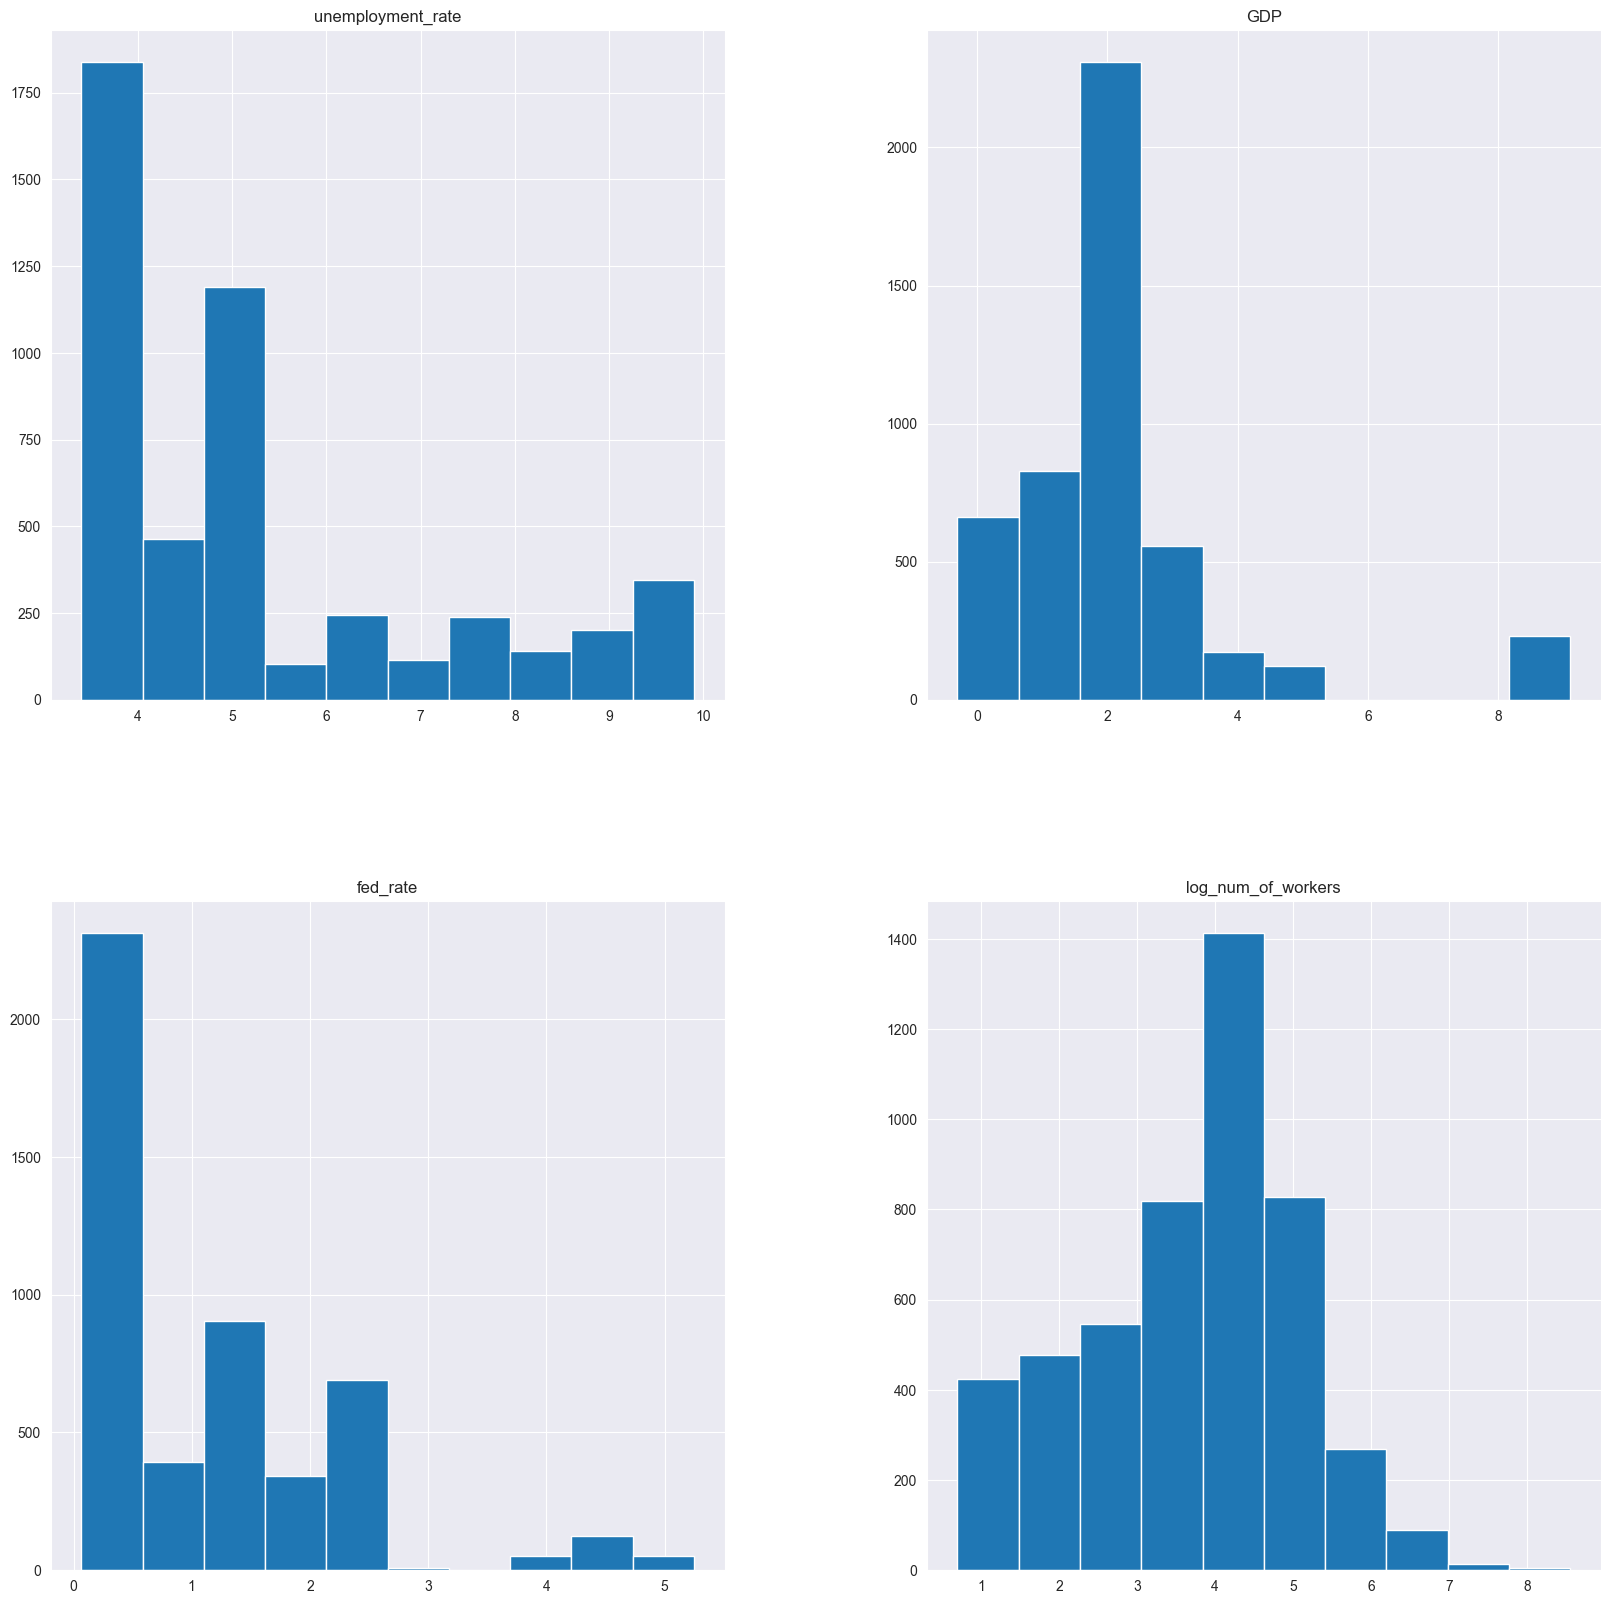

In [22]:
df2 = df[['unemployment_rate', 'GDP', 'fed_rate', 'log_num_of_workers']]
df2.hist(figsize=(20,20))
plt.savefig('plots/histogram.pdf')

<AxesSubplot: >

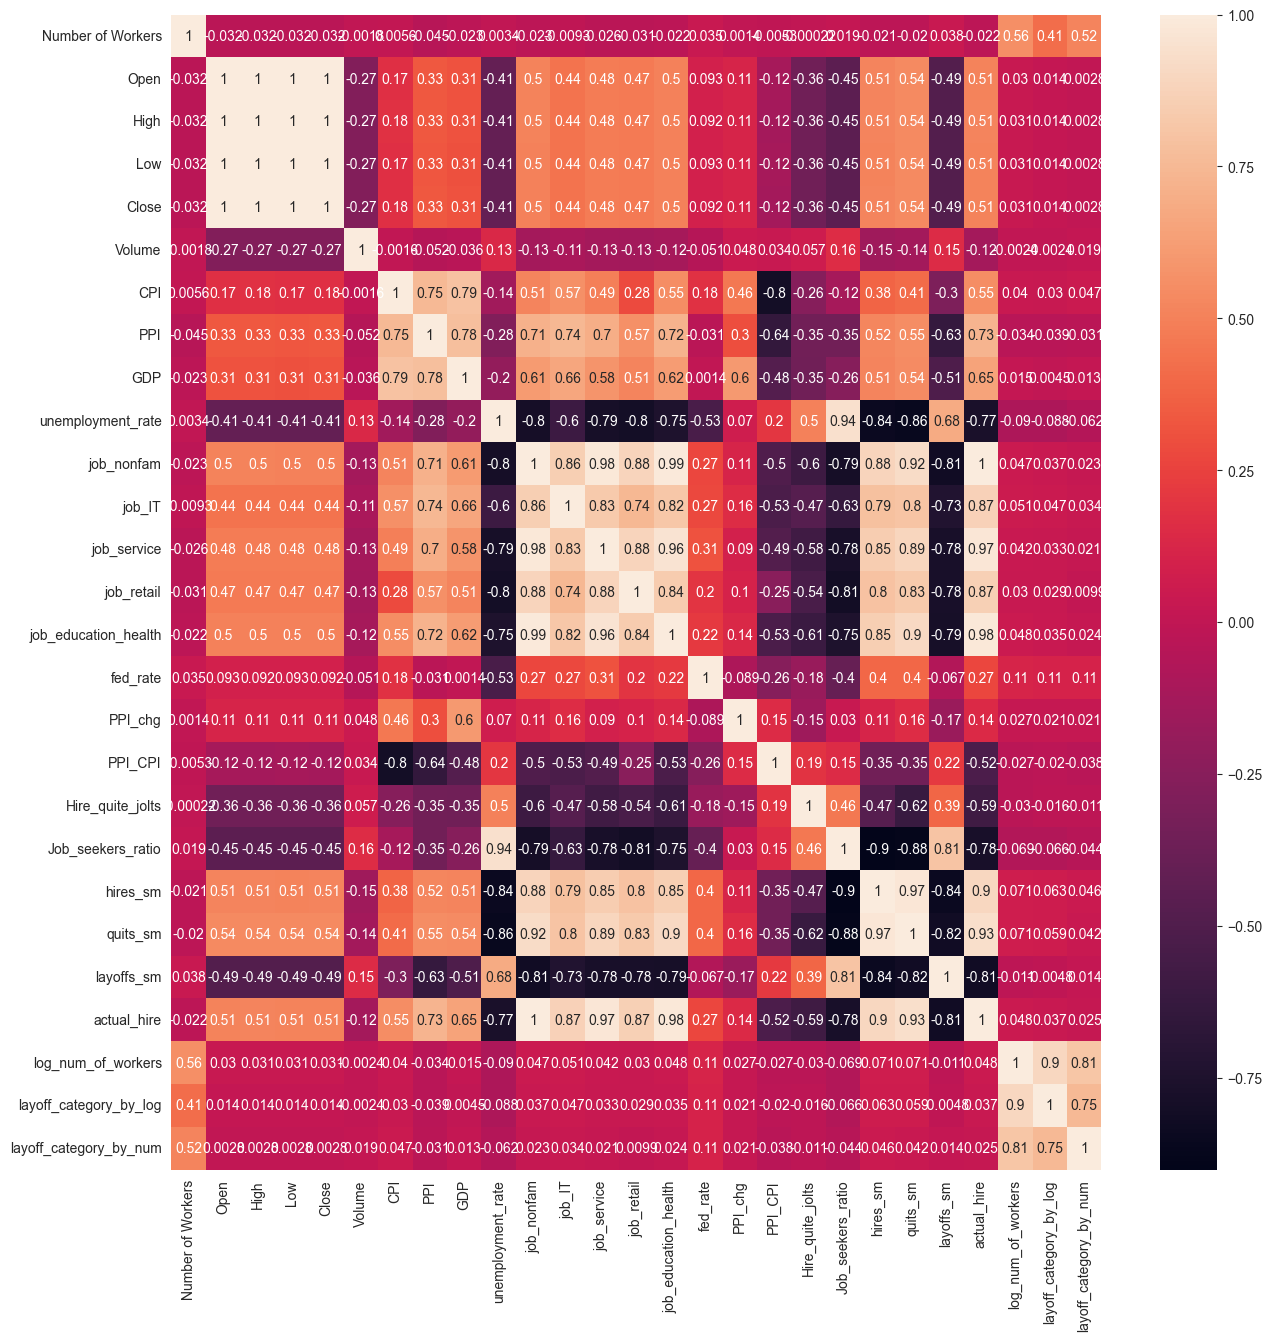

In [36]:
fig, ax = plt.subplots(figsize=(15,15))    
sns.heatmap(df.corr(), annot=True, ax=ax)

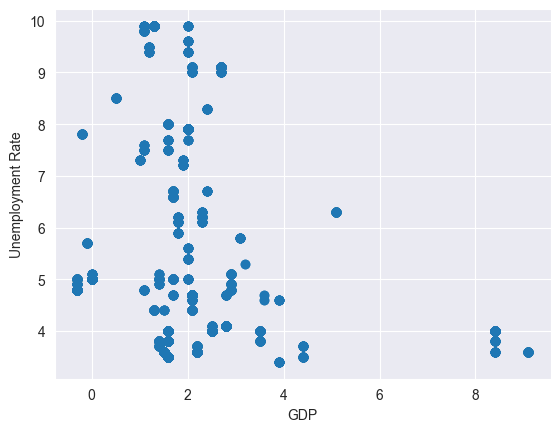

In [23]:
# Visualize the relationship between two numerical columns using a scatter plot
plt.scatter(df['GDP'], df['unemployment_rate'])
plt.xlabel('GDP')
plt.ylabel('Unemployment Rate')
plt.savefig('plots/GDP_unemployment.pdf')

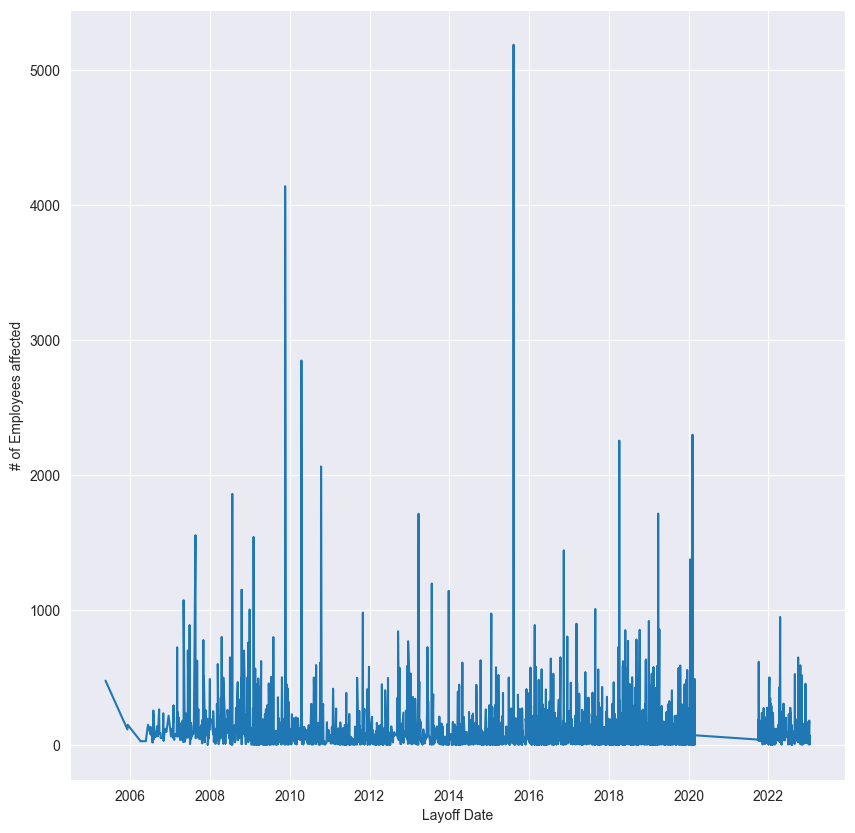

In [38]:
sortedDF = df.sort_values(by=['WARN Received Date'], ascending=True)
fig, ax = plt.subplots(figsize=(10, 10))
 
plt.plot(sortedDF['WARN Received Date'], sortedDF['Number of Workers'])
plt.xlabel('Layoff Date')
plt.ylabel('# of Employees affected')
plt.show()

# Feature Engineering


In [6]:
df['Price Volatility'] = df['High'] - df['Low']

In [7]:
# One hot encode
df = pd.get_dummies(df, columns=['Industry'])

# ML Models

In [8]:
X = df.drop(["WARN Received Date", "Number of Workers", "layoff_category_by_log", "by_month","Date"], axis=1)
y = df["layoff_category_by_num"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1707)

## MLR

In [42]:
MLR = LinearRegression().fit(X_train, y_train)
preds = MLR.predict(X_test)

In [43]:
print("R^2 : ", r2_score(y_test, preds))
print("MAE :", mean_absolute_error(y_test,preds))
print("RMSE:",np.sqrt(mean_squared_error(y_test, preds)))

R^2 :  0.6625892774850062
MAE : 0.28330174886017073
RMSE: 0.39312342805428024


## SHAP

In [44]:
#explainer = shap.Explainer(MLR.predict, X_train)
#shap_values = explainer(X_test)

In [45]:
#shap.summary_plot(shap_values, X_test)

## MLR Ordinary Least Squares

In [46]:
#X_train = sm.add_constant(X_train) # adding a constant

model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train)

print_model = model.summary()
print(print_model)

                              OLS Regression Results                              
Dep. Variable:     layoff_category_by_num   R-squared:                       0.674
Model:                                OLS   Adj. R-squared:                  0.672
Method:                     Least Squares   F-statistic:                     243.0
Date:                    Wed, 26 Apr 2023   Prob (F-statistic):               0.00
Time:                            20:23:00   Log-Likelihood:                -1822.3
No. Observations:                    3906   AIC:                             3713.
Df Residuals:                        3872   BIC:                             3926.
Df Model:                              33                                         
Covariance Type:                nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

## GaussianNB

In [47]:
gnb = GaussianNB()
preds = gnb.fit(X_train, y_train).predict(X_test)

In [48]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != preds).sum()))

Number of mislabeled points out of a total 977 points : 529


In [49]:
accuray = accuracy_score(preds, y_test)
f1 = f1_score(preds, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.458546571136131
F1 Score: 0.5554566890291904


## Random forest

In [50]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier()

modelRF = SelectFromModel(rfc).fit(X_train, y_train)

X_train_newRF = modelRF.transform(X_train)
feature_names = X_train.columns[modelRF.get_support()]
X_test_newRF = X_test[feature_names]

rfc_new = RandomForestClassifier().fit(X_train_newRF, y_train)

predsRF = rfc_new.predict(X_test_newRF)

accuracy_score(predsRF, y_test)

X has feature names, but RandomForestClassifier was fitted without feature names


1.0

## Extra Trees Classifier

In [51]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

modelETC = SelectFromModel(etc).fit(X_train, y_train)

X_train_newETC = modelETC.transform(X_train)
feature_names = X_train.columns[modelETC.get_support()]
X_test_newETC = X_test[feature_names]

etc_new = ExtraTreesClassifier().fit(X_train_newETC, y_train)

predsETC = etc_new.predict(X_test_newETC)

accuracy_score(predsETC, y_test)

X has feature names, but ExtraTreesClassifier was fitted without feature names


1.0

## SGD

In [52]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, alpha=1, penalty='l1'))
preds = clf.fit(X_train, y_train).predict(X_test)

In [53]:
param_grid = {'alpha' : [.001,.01,.1,1,10,100],
              'penalty': ['l2', 'l1', 'elasticnet', None]}

gridsearch = GridSearchCV(SGDClassifier(max_iter=1000, tol=1e-3), param_grid, cv=10).fit(X_train, y_train)

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
Maximum number of iteration reached before convergence.

In [54]:
gridsearch.best_params_

{'alpha': 10, 'penalty': 'l1'}

In [55]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, alpha=1, penalty='l1'))
preds = clf.fit(X_train, y_train).predict(X_test)

In [56]:
accuray = accuracy_score(preds, y_test)
f1 = f1_score(preds, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.45752302968270214
F1 Score: 0.6278089887640449


# Feature Selection

In [57]:
model0 = SelectFromModel(MLR, prefit=True)

In [58]:
X_train_new = model0.transform(X_train)

X has feature names, but SelectFromModel was fitted without feature names


In [59]:
feature_names = X_train.columns[model0.get_support()]

In [60]:
print('Feature Names \n',feature_names)

Feature Names 
 Index(['Hire_quite_jolts', 'Job_seekers_ratio', 'quits_sm', 'layoffs_sm',
       'log_num_of_workers', 'layoff_category_quantile',
       'Industry_Energy Select Sector SPDR Fund',
       'Industry_Materials Select Sector SPDR Fund',
       'Industry_Utilities Select Sector SPDR Fund'],
      dtype='object')


In [61]:
X_test_new = X_test[feature_names]

In [62]:
X_test_new = X_test[['Open','GDP','unemployment_rate', 'year', 'Hires_jolts',
       'Layoffs_jolts', 'Hire_quite_jolts', 'Job_seekers_ratio', 'Industry_Consumer Discretionary Select Sector SPDR Fund', 'Industry_Energy Select Sector SPDR Fund','Industry_Financial Select Sector SPDR Fund','Industry_Industrial Select Sector SPDR Fund','Industry_Materials Select Sector SPDR Fund','Industry_Utilities Select Sector SPDR Fund']]

KeyError: "['year', 'Hires_jolts', 'Layoffs_jolts'] not in index"

In [ ]:
MLR0 = LinearRegression().fit(X_train_new, y_train)
preds = MLR0.predict(X_test_new)

In [ ]:
preds = np.round(preds)

In [ ]:
y_test = y_test.cat.codes.astype(np.float64)

In [ ]:
accuracy_score(preds,y_test)

# Kernel SVM

In [ ]:
kernel_svm_model = SVC(kernel="rbf")

#Fit the Kernel SVM model on the training data
kernel_svm_model.fit(X_train, y_train)

#Display summary of the Kernel SVM model
print(kernel_svm_model)

#Predict on the training data using the Kernel SVM model
kernel_svm_model_predicted_training = kernel_svm_model.predict(X_train)

#Predict on the test data using the Kernel SVM model
kernel_svm_model_predicted_test = kernel_svm_model.predict(X_test)



In [ ]:
# Accuracy
kernel_svm_model_training_accuracy = metrics.accuracy_score(y_train, kernel_svm_model_predicted_training)
kernel_svm_model_test_accuracy = metrics.accuracy_score(y_test, kernel_svm_model_predicted_test)

print('Training Accuracy: ' + str(kernel_svm_model_training_accuracy))
print('Test Accuracy: ' + str(kernel_svm_model_test_accuracy))

#Summarize the fit of the Kernel SVM model on the training data
print(metrics.classification_report(y_train, kernel_svm_model_predicted_training))
print(metrics.confusion_matrix(y_train, kernel_svm_model_predicted_training))

#Summarize the fit of the Kernel SVM model on the test data
print(metrics.classification_report(y_test, kernel_svm_model_predicted_test))
print(metrics.confusion_matrix(y_test, kernel_svm_model_predicted_test))

# Neural Net

In [14]:
neural_network_model = MLPClassifier(alpha=1, hidden_layer_sizes = (20, 10))

#Fit the simple neural network model on the training data
neural_network_model.fit(X_train, y_train)

#Display summary of the simple neural network model
print(neural_network_model)

#Predict on the training data using the simple neural network model
neural_network_model_predicted_training  = neural_network_model.predict(X_train)

#Predict on the test data using the simple neural network model
neural_network_model_predicted_test = neural_network_model.predict(X_test)

MLPClassifier(alpha=1, hidden_layer_sizes=(20, 10))


In [15]:
#Accuracy
neural_network_model_training_accuracy = metrics.accuracy_score(y_train, neural_network_model_predicted_training)
neural_network_model_test_accuracy = metrics.accuracy_score(y_test, neural_network_model_predicted_test)

print('Training Accuracy: ' + str(neural_network_model_training_accuracy))
print('Test Accuracy: ' + str(neural_network_model_test_accuracy))

#Summarize the fit of the simple neural network model on the training data
print(metrics.classification_report(y_train, neural_network_model_predicted_training))
print(metrics.confusion_matrix(y_train, neural_network_model_predicted_training))

#Summarize the fit of the simple neural network model on the test data
print(metrics.classification_report(y_test, neural_network_model_predicted_test))
print(metrics.confusion_matrix(y_test, neural_network_model_predicted_test))

Training Accuracy: 0.4915514592933948
Test Accuracy: 0.458546571136131
              precision    recall  f1-score   support

           1       0.49      0.99      0.65      1900
           2       0.58      0.03      0.05      1571
           3       0.00      0.00      0.00       435

    accuracy                           0.49      3906
   macro avg       0.36      0.34      0.24      3906
weighted avg       0.47      0.49      0.34      3906

[[1875   25    0]
 [1526   45    0]
 [ 427    8    0]]
              precision    recall  f1-score   support

           1       0.46      0.98      0.62       447
           2       0.48      0.03      0.05       416
           3       0.00      0.00      0.00       114

    accuracy                           0.46       977
   macro avg       0.31      0.33      0.22       977
weighted avg       0.41      0.46      0.31       977

[[437  10   0]
 [405  11   0]
 [112   2   0]]


/Users/damcewan/Documents/GitHub/Layoffs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damcewan/Documents/GitHub/Layoffs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/damcewan/Documents/GitHub/Layoffs/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av